In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-talk', 'seaborn-ticks'])

import cartopy.crs as ccrs

import numpy as np
import pandas as pd
import xarray as xr

import warnings; warnings.simplefilter('ignore')

Here I want to test the idea of building local-correlation maps on varying distance scales.

The basic idea stems from the fact that climate-induced changes in O3 have a very strong regional signal:

In [2]:
ds = xr.open_dataset("../data/processed/seasonal_timeseries/fgm.O3_SRF.JJA.nc")
o3 = ds['O3_SRF'] * 1e9
diff = (o3.sel(dec='2085-2115', pol='REF') - o3.sel(dec='1980-2010', pol='REF')).mean(['time', 'ic'])

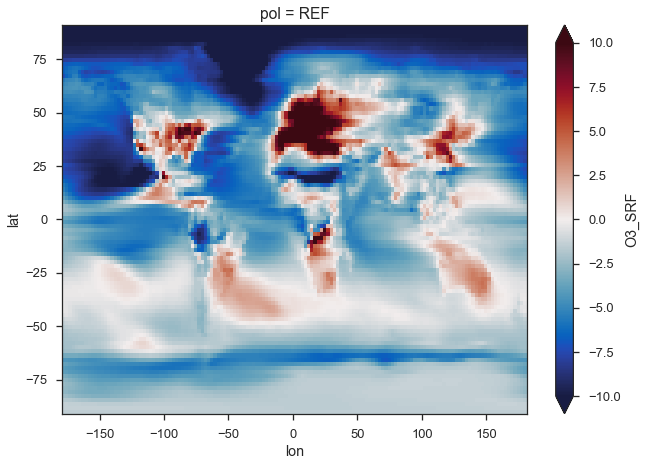

In [3]:
from darpy.plot import geo_plot, make_geoaxes
from darpy.utilities import shift_roll
import cmocean

_diff = shift_roll(diff)
_diff.plot.pcolormesh(infer_intervals=True, vmin=-10, vmax=10, cmap=cmocean.cm.balance)

We can use this pattern directly in our clustering analysis to help identify regions with similar changes. But it may also be useful to take this a step further and correlate local changes with those in the region. To do this, we can pick a radius around each cell, compute the average timeseries across that region, and regress against the local timeseries.

In [4]:
from air_quality.util import fgm_unstack_years

o3_flat = fgm_unstack_years(o3.to_dataset())['O3_SRF'].sel(pol='REF')

In [5]:
from darpy import global_avg

dlon, dlat = 10., 10.
lon, lat = 360-60, 40

local = o3_flat.sel(lon=lon, lat=lat, method='nearest').mean('ic')
region = o3_flat.sel(lon=slice(lon-dlon, lon+dlon), lat=slice(lat-dlat, lat+dlat)).mean('ic').pipe(global_avg)

combined = pd.concat([
    local.rename('local').to_dataframe()['local'],
    region.rename('region').to_dataframe()['region']
], axis=1)

(25, 39)

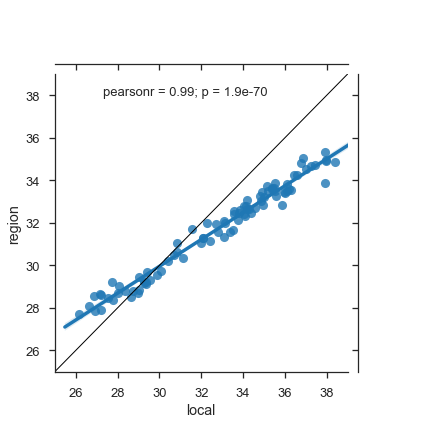

In [6]:
import seaborn as sns
from scipy.stats import pearsonr

g = sns.JointGrid('local', 'region', combined)
g.plot_joint(sns.regplot)
g.annotate(pearsonr)
xlo, xhi = map(int, g.ax_joint.get_xlim())
g.ax_joint.plot([xlo, xhi], [xlo, xhi], color='k', lw=1)
g.ax_joint.set_xlim(xlo, xhi)
g.ax_joint.set_ylim(xlo, xhi)

That didn't quite work so well... I guess correlations at any one grid cell for a given year are always going to be similar. Maybe monthly correlations will show something a bit more interesting?

In [29]:
ds = xr.open_dataset("../data/processed/fgm.air_quality.monthly.nc")
o3 = ds['O3_SRF'] * 1e9
o3_flat = fgm_unstack_years(o3.to_dataset(), monthly=True)['O3_SRF'].sel(pol='REF')

In [36]:
from darpy import global_avg

dlon, dlat = 30., 30.
lon, lat = 360-60, 40

local = o3_flat.sel(lon=lon, lat=lat, method='nearest').mean('ic')
region = o3_flat.sel(lon=slice(lon-dlon, lon+dlon), lat=slice(lat-dlat, lat+dlat)).mean('ic').pipe(global_avg)

combined = pd.concat([
    local.rename('local').to_dataframe()['local'],
    region.rename('region').to_dataframe()['region']
], axis=1)

(18, 66)

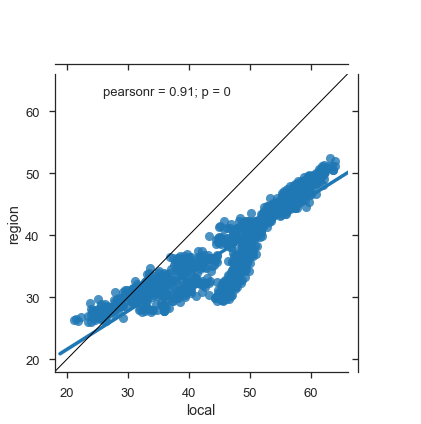

In [37]:
import seaborn as sns
from scipy.stats import pearsonr

g = sns.JointGrid('local', 'region', combined)
g.plot_joint(sns.regplot)
g.annotate(pearsonr)
xlo, xhi = map(int, g.ax_joint.get_xlim())
g.ax_joint.plot([xlo, xhi], [xlo, xhi], color='k', lw=1)
g.ax_joint.set_xlim(xlo, xhi)
g.ax_joint.set_ylim(xlo, xhi)

There's definitely a bit more variance here but the correlation coefficients are still extraordinarly high. I'm not sure we'd get anything useful from this analysis, and there's a bit more computational work that would have to be done for this to work.